# Robustness of policies

In [1]:
# read in all the needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from ema_workbench.analysis import parcoords
from ema_workbench import (MultiprocessingEvaluator, Policy)
from ema_workbench.util import ema_logging


from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

C:\Users\thori\Anaconda3\envs\mbdm1\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


The results from the optimisation are read in. Only policies i.e. lever combinations are kept, that result in less than 0.01 expected deaths for A.5 Deventer. This ensures that all lever combinations that are considered for policies actually perform well over the worst case scenarios.

In [47]:
results = []
for i in range(5):
    results_scenario = pd.read_csv(f'outcomes/15k_results_optimisation_scenario{i}.csv')
    results_scenario = results_scenario[results_scenario['A.5_Expected Number of Deaths'] <= 1]
    results.append(results_scenario)

In [48]:
results[3].columns

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

Following, the results for the 4 other dike rings (non-Deventer) are added up. This is due to the comparison between Deventer and the rest. Results for dike ring 4 (Gorssel) are kept to be able to directly compare Deventer's results to those of its neighbour Gorssel.

In [49]:
for i in range(len(results)):
    results[i]['Other Areas Total Number of Deaths'] = 0  
    results[i]['Other Areas Total Costs'] = 0
    results[i]['Scenario number'] = i
    
    for area in range(1,5):
        results[i]['Other Areas Total Number of Deaths'] += results[i][f'A.{area}_Expected Number of Deaths']
        results[i]['Other Areas Total Costs'] += results[i][f'A.{area} Total Costs']
    
    results[i] = results[i].drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [50]:
combined_results = results[0].append([results[1], results[2], results[3], results[4]], ignore_index=True)

From the 5 scenarios that were put into the optimisation (see notebook multi-scenario MORDM.ipynb), the maximum i.e. worst values for each of those scenarios for each column as well as the minimum i.e. best outcomes for those 5 optimised scenarios are taken. Then, the experiments matching those outcomes are are stored. 

In [51]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs']


lever_array = outcomes_array + ['Scenario number']

result_best_worst_scenarios = []
for i in range(len(results)):
    result_best_worst = []
    result_worst = results[i].loc[results[i][outcomes_array].idxmax()]

    result_best = results[i].loc[results[i][outcomes_array].idxmin()]

    result_best_worst = result_best.append(result_worst)
    
    result_best_worst = result_best_worst.drop(lever_array, axis=1)
    result_best_worst_scenarios.append(result_best_worst)

In [52]:
len(result_best_worst_scenarios)

5

In [53]:
result_best_worst_all = result_best_worst_scenarios[0].append([result_best_worst_scenarios[1], result_best_worst_scenarios[2], result_best_worst_scenarios[3], result_best_worst_scenarios[4]], ignore_index=True)
result_best_worst_all

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,1,0,0,1,0,1,0,1,...,4,3,0,5,3,0,0,1,4,3
1,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,4,6,6,7,0,0
3,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
4,0,0,0,0,0,0,0,0,0,0,...,5,5,0,4,6,1,3,6,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,0,0,0,1,1,0,0,...,0,5,3,0,4,0,1,1,2,1
76,1,1,1,1,0,1,1,1,1,1,...,2,4,1,7,2,0,0,7,3,6
77,0,0,0,0,0,0,1,1,1,0,...,3,1,1,3,4,0,4,0,2,0
78,0,0,1,0,0,0,1,0,0,0,...,2,0,0,1,6,0,0,9,2,2


It results, that some experiments are the same. Duplicates will be removed. Then, out of those experiments policies are created. 

In [54]:
duplicateDFRow = result_best_worst_all[result_best_worst_all.duplicated()]
result_best_worst_all_no_duplicates = result_best_worst_all.drop(duplicateDFRow.index)

In [55]:
result_best_worst_all_no_duplicates

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,1,0,0,1,0,1,0,1,...,4,3,0,5,3,0,0,1,4,3
1,0,0,1,0,0,0,0,0,1,1,...,3,0,0,0,4,0,4,10,1,5
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,4,6,6,7,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,0,4,6,1,3,6,2,6
5,0,1,1,0,0,0,1,0,0,1,...,5,1,6,0,4,2,0,7,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,0,0,0,0,0,1,1,1,0,...,3,1,1,3,4,0,4,0,2,0
75,0,0,0,0,0,0,1,1,0,0,...,0,5,3,0,4,0,1,1,2,1
76,1,1,1,1,0,1,1,1,1,1,...,2,4,1,7,2,0,0,7,3,6
78,0,0,1,0,0,0,1,0,0,0,...,2,0,0,1,6,0,0,9,2,2


In [56]:
policies = []
for j, row in result_best_worst_all_no_duplicates.iterrows():
        policy = Policy(f'scenario option {j}', **row.to_dict())
        policies.append(policy)

These policies represent the policies that perform best and worst over the worst-case scenarios but still meet the set threshold of 0.01 deaths in Deventer. 1000 scenarios are run with these policies to explore each policy's robustness.

In [15]:

ema_logging.log_to_stderr(level='INFO')


with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 66 policies * 1 model(s) = 66000 experiments
[MainProcess/INFO] 6600 cases completed
[MainProcess/INFO] 13200 cases completed
[MainProcess/INFO] 19800 cases completed
[MainProcess/INFO] 26400 cases completed
[MainProcess/INFO] 33000 cases completed
[MainProcess/INFO] 39600 cases completed
[MainProcess/INFO] 46200 cases completed
[MainProcess/INFO] 52800 cases completed
[MainProcess/INFO] 59400 cases completed
[MainProcess/INFO] 66000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
experiments = reeevaluation_results[0]
results = pd.DataFrame(reeevaluation_results[1])

In [17]:
results.to_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments.to_csv('./outcomes/reevaluation_promising_experiments.csv')


# Analysis
In this section, first the results from the previous run are read in. Then, the policies will be evaluated considering robustness. The robustness metrics Maximin and Minimax regret will be used. 

In [2]:
# read in results
results_load = pd.read_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments_load = pd.read_csv('./outcomes/reevaluation_promising_experiments.csv')

In [3]:
# adapt dataframes slightly: combine A.1 to A.4 for comparison reasons, 
# delete no longer needed columns (A.1 to A.3, A.4 kept for direct comparison)
results_load['Other Areas Total Number of Deaths'] = 0  
results_load['Other Areas Total Costs'] = 0

for area in range(1,5):
    results_load['Other Areas Total Number of Deaths'] += results_load[f'A.{area}_Expected Number of Deaths']
    results_load['Other Areas Total Costs'] += results_load[f'A.{area} Total Costs']

results_load = results_load.drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
   'A.2_Expected Number of Deaths', 'A.3 Total Costs',
   'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [4]:
# rename the policys from 'scenario option xx' to 'policy xx'
experiments_load['policy'] = experiments_load['policy'].str.replace('scenario option', 'Policy')

In [5]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs']


lever_array = outcomes_array + ['Scenario number']

#### Functions for the further use

In [6]:
# function to find which outcomes are dominated by others,
# takes in the policy outcomes, gives back the index of those that are dominated i.e. that can be dropped later

def dominate(policy_outcomes):
    
    todrop = []
    for i in range(len(policy_outcomes)):
        for j in range(len(policy_outcomes)):
            if j == i:
                pass
            else: # if all values of one policy greater than those of others
                dominated = policy_outcomes.iloc[i,:] >= policy_outcomes.iloc[j,:]
                if dominated.sum() == len(policy_outcomes.columns):
                    todrop.append(i)
    return np.unique(todrop)

In [34]:
# function to create a parallel axis plot and save the figure
# takes in dataframe with outcomes of policies (the dominated one, so not as many to plot)
# gives out plot and saves figure to figures-folder

def axes_paraplot(dominate_policy, pref, name_figure):
    
    policy_names = pref.index.values[dominate_policy.index.values] # for legend
    
    limits = parcoords.get_limits(dominate_policy)
    axes = parcoords.ParallelAxes(limits)
    dominate_policy = dominate_policy.reset_index(drop=True)
    for i in range(len(dominate_policy)):   
        axes.plot(dominate_policy.iloc[i], label=policy_names[i], color=sns.color_palette('hls', len(dominate_policy))[i])
    axes.legend()

    plt.savefig(f'./figures/{name_figure}.png', bbox_inches="tight")
    return policy_names

### Maximin
Maximin is taking into account the worst case scenario the worst thing that could happen.

"the maximin metric has a very high level of intrinsic risk aversion, as its calculation is only based on the worst performance over all scenarios considered (Table 3), leading to a very conservative solution (Bertsimas & Sim, 2004). Similarly, the minimax regret metric assumes that the selected decision alternative will have the largest regret possible, as its calculation is based on the worst-case relative performance" https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649


In [8]:
policy_outcomes_maximin = results_load
policy_outcomes_maximin['policy'] = experiments_load['policy'] 
policy_outcomes_maximin['scenario'] = experiments_load['scenario'] 

least_pref = pd.DataFrame()
for outcome in outcomes_array:
    least_pref[outcome] = policy_outcomes_maximin.groupby(['policy']).max()[outcome]


In [9]:
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC']
least_pref = least_pref.set_axis(short_names, axis=1)
least_pref = least_pref.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])



x_maximin = least_pref.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_maximin_scaled = min_max_scaler.fit_transform(x_maximin)
least_pref_norm = pd.DataFrame(x_maximin_scaled)


least_pref_norm = least_pref_norm.set_axis(short_names, axis=1)
least_pref_norm = least_pref_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])


In [28]:
least_pref

,A.4_Deaths,A.5_Deaths,OTD,A.4_TC,A.5_TC,OTC,RfR Costs,Evac C
policy,,,,,,,,
Policy 0,0.009499,0.090317,0.618976,7.997940e+07,4.325901e+08,2.057562e+09,1.343800e+09,24455.544144
Policy 1,0.002639,0.000000,0.271024,8.408985e+07,1.462890e+08,1.933115e+09,4.789000e+08,96364.291453
Policy 10,0.008613,0.119143,0.394269,1.565935e+08,1.167809e+09,3.309407e+09,0.000000e+00,56190.286739
Policy 11,0.052106,0.590559,3.314296,1.318765e+08,7.799484e+08,3.605853e+09,0.000000e+00,0.000000
Policy 12,0.002646,0.016587,0.081714,7.546212e+07,3.381949e+08,1.245455e+09,2.015900e+09,26339.311622
...,...,...,...,...,...,...,...,...
Policy 76,0.003166,0.002461,0.054460,8.466587e+07,1.577375e+08,7.710136e+08,1.792200e+09,25231.714596
Policy 78,0.032331,0.012449,2.471402,8.804259e+07,1.415077e+08,2.423431e+09,2.365000e+08,0.000000
Policy 79,0.017480,0.001819,0.276015,1.544331e+08,1.687970e+08,1.632886e+09,1.153000e+08,11136.968644


In [10]:
least_pref_norm_45 = least_pref_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC']]
least_pref_norm_others5 = least_pref_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C']]

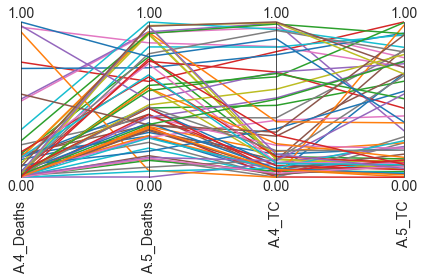

In [11]:
limits = parcoords.get_limits(least_pref_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_45)
plt.savefig('./figures/maximin_norm_45_undominated.png')

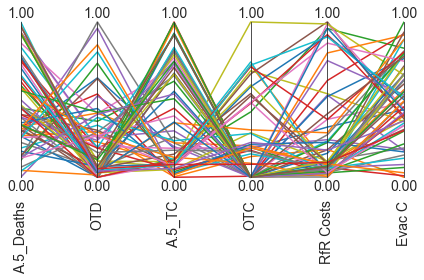

In [12]:
limits = parcoords.get_limits(least_pref_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_others5)
plt.savefig('./figures/maximin_norm_others5_undominated.png')

In [13]:
least_pref_norm_45_dominate = least_pref_norm_45.drop(dominate(least_pref_norm_45))
least_pref_norm_others5_dominate = least_pref_norm_others5.drop(dominate(least_pref_norm_others5))

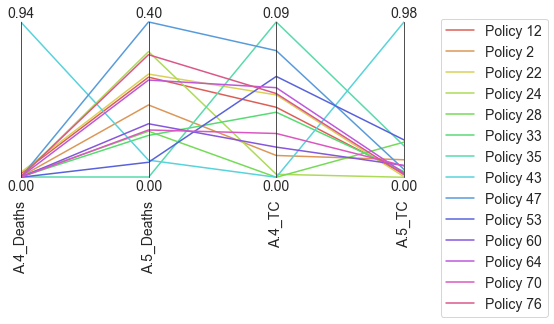

In [42]:
policies_maximin_45 = axes_paraplot(least_pref_norm_45_dominate, least_pref, 'maximin_norm_45_dominated')

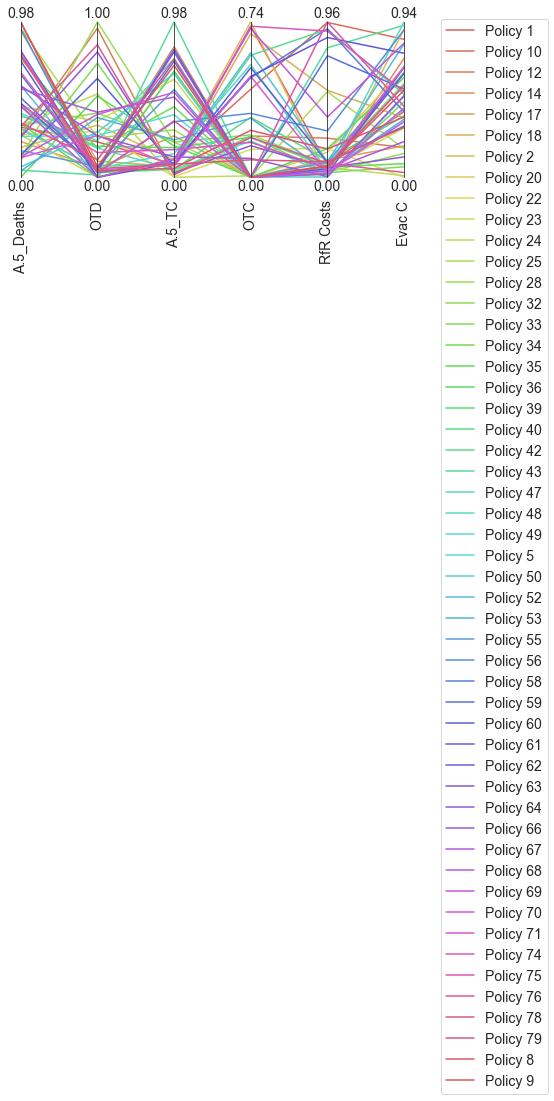

In [43]:
policies_maximin_others5 = axes_paraplot(least_pref_norm_others5_dominate, least_pref, 'maximin_norm_others5_dominated')

In [44]:
policies_maximin_others5

array(['Policy 1', 'Policy 10', 'Policy 12', 'Policy 14', 'Policy 17',
       'Policy 18', 'Policy 2', 'Policy 20', 'Policy 22', 'Policy 23',
       'Policy 24', 'Policy 25', 'Policy 28', 'Policy 32', 'Policy 33',
       'Policy 34', 'Policy 35', 'Policy 36', 'Policy 39', 'Policy 40',
       'Policy 42', 'Policy 43', 'Policy 47', 'Policy 48', 'Policy 49',
       'Policy 5', 'Policy 50', 'Policy 52', 'Policy 53', 'Policy 55',
       'Policy 56', 'Policy 58', 'Policy 59', 'Policy 60', 'Policy 61',
       'Policy 62', 'Policy 63', 'Policy 64', 'Policy 66', 'Policy 67',
       'Policy 68', 'Policy 69', 'Policy 70', 'Policy 71', 'Policy 74',
       'Policy 75', 'Policy 76', 'Policy 78', 'Policy 79', 'Policy 8',
       'Policy 9'], dtype=object)

In [45]:
policies_maximin_45

array(['Policy 12', 'Policy 2', 'Policy 22', 'Policy 24', 'Policy 28',
       'Policy 33', 'Policy 35', 'Policy 43', 'Policy 47', 'Policy 53',
       'Policy 60', 'Policy 64', 'Policy 70', 'Policy 76'], dtype=object)

### Minimax Regret Criterion
The Minimax Regret Criterion is a technique used to make decisions under uncertainty. The context of a decision making process under uncertainty, a decision maker is faced to uncertain states of nature and a number of decision alternatives that can be chosen. The decision made and the final state of nature (which the decision maker does not know beforehand) determines the payoff.

Under this Minimax Regret Criterion, the decision maker calculates the maximum opportunity loss values (or also known as regret) for each alternative, and then she chooses the decision that has the lowest maximum regret.

The regret or opportunity loss for a specific alternative, at a given state of nature, is how much we lose by choosing that alternative and not the optimal alternative, given that state of nature (if the current alternative IS the optima alternative, then the opportunity loss for that alternative, given the state of nature, is 0).

https://mathcracker.com/minimax-regret-criterion-calculator

In [16]:
policy_outcomes = results_load
policy_outcomes_regret = results_load.copy()
# add scenario and policy to dataframe
policy_outcomes_regret['scenario'] = experiments_load['scenario']
policy_outcomes_regret['policy'] = experiments_load['policy']

most_pref = pd.DataFrame()
for outcome in outcomes_array:
    most_pref[outcome] = policy_outcomes_regret.groupby(['policy']).min()[outcome] 

most_pref.reset_index(inplace=True)
#most_pref = most_pref.drop('scenario', axis=1)

In [17]:
most_pref

,policy,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
0,Policy 0,8.453408e+06,0.0,9.545879e+07,0.0,1.343800e+09,0.000000,0.0,4.063320e+08
1,Policy 1,2.078505e+07,0.0,1.462890e+08,0.0,4.789000e+08,0.000000,0.0,2.127035e+08
2,Policy 10,1.692524e+07,0.0,7.770751e+07,0.0,0.000000e+00,141.914208,0.0,3.840111e+08
3,Policy 11,1.106877e+07,0.0,7.074086e+07,0.0,0.000000e+00,0.000000,0.0,2.484557e+08
4,Policy 12,7.332080e+06,0.0,1.341380e+08,0.0,2.015900e+09,0.000000,0.0,6.902568e+08
...,...,...,...,...,...,...,...,...,...
61,Policy 76,7.332080e+06,0.0,1.389496e+08,0.0,1.792200e+09,0.000000,0.0,2.762047e+08
62,Policy 78,1.258646e+07,0.0,1.303402e+08,0.0,2.365000e+08,0.000000,0.0,2.036767e+08
63,Policy 79,2.811056e+07,0.0,1.643440e+08,0.0,1.153000e+08,0.000000,0.0,4.911282e+08
64,Policy 8,7.332080e+06,0.0,7.908444e+07,0.0,8.460000e+07,0.000000,0.0,2.497830e+08


In [18]:
policy_outcomes_regret

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs,policy,scenario
0,8.453408e+06,0.000000,1.004570e+08,0.001221,1.343800e+09,115.624205,0.000000,4.063320e+08,Policy 0,0
1,8.453408e+06,0.000000,9.545879e+07,0.000000,1.343800e+09,24.535732,0.001007,4.092804e+08,Policy 0,1
2,8.453408e+06,0.000000,1.192903e+08,0.011230,1.343800e+09,1135.063294,0.000000,4.063320e+08,Policy 0,2
3,8.453408e+06,0.000000,9.905568e+07,0.001133,1.343800e+09,108.468194,0.000000,4.063320e+08,Policy 0,3
4,8.453408e+06,0.000000,9.545879e+07,0.000000,1.343800e+09,0.000000,0.000000,4.063320e+08,Policy 0,4
...,...,...,...,...,...,...,...,...,...,...
65995,2.896907e+07,0.000132,1.643440e+08,0.000000,1.153000e+08,19.925985,0.000132,4.919867e+08,Policy 79,995
65996,3.282399e+07,0.001286,1.643440e+08,0.000000,1.153000e+08,238.674855,0.001286,4.958416e+08,Policy 79,996
65997,3.286032e+07,0.001214,1.643440e+08,0.000000,1.153000e+08,197.857654,0.001214,4.958779e+08,Policy 79,997
65998,2.866368e+07,0.000142,1.643440e+08,0.000000,1.153000e+08,20.395824,0.000142,4.916813e+08,Policy 79,998


In [11]:
for i in range(len(policy_outcomes_regret)):
    for j in range(len(most_pref)):
        if policy_outcomes_regret['policy'][i] == most_pref['policy'][j]:
            for outcome in outcomes_array:
                policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]

<ipython-input-11-f1c685773121>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]


In [12]:
policy_outcomes_regret.to_csv('./outcomes/minimax_regret_outcomes.csv')

In [19]:
policy_outcomes_regret = pd.read_csv('./outcomes/minimax_regret_outcomes.csv')

In [20]:
worst_regret = policy_outcomes_regret.groupby('policy').max().drop(['scenario', 'Unnamed: 0'], axis=1)
worst_regret

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
policy,,,,,,,,
Policy 0,7.152599e+07,0.009499,3.371313e+08,0.090317,0.0,24455.544144,0.618976,1.651230e+09
Policy 1,6.330480e+07,0.002639,0.000000e+00,0.000000,0.0,96364.291453,0.271024,1.720411e+09
Policy 10,1.396683e+08,0.008613,1.090102e+09,0.119143,0.0,56048.372531,0.394269,2.925395e+09
Policy 11,1.208078e+08,0.052106,7.092075e+08,0.590559,0.0,0.000000,3.314296,3.357398e+09
Policy 12,6.813004e+07,0.002646,2.040568e+08,0.016587,0.0,26339.311622,0.081714,5.551981e+08
...,...,...,...,...,...,...,...,...
Policy 76,7.733379e+07,0.003166,1.878788e+07,0.002461,0.0,25231.714596,0.054460,4.948089e+08
Policy 78,7.545613e+07,0.032331,1.116753e+07,0.012449,0.0,0.000000,2.471402,2.219754e+09
Policy 79,1.263225e+08,0.017480,4.452985e+06,0.001819,0.0,11136.968644,0.276015,1.141757e+09


In [21]:
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC']

worst_regret = worst_regret.set_axis(short_names, axis=1)
worst_regret = worst_regret.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])


x_minimax = worst_regret.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_minimax_scaled = min_max_scaler.fit_transform(x_minimax)
worst_regret_norm = pd.DataFrame(x_minimax_scaled)


worst_regret_norm = worst_regret_norm.set_axis(short_names, axis=1)
worst_regret_norm = worst_regret_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])


In [22]:
worst_regret_norm_45 = worst_regret_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC']]
worst_regret_norm_others5 = worst_regret_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C']]

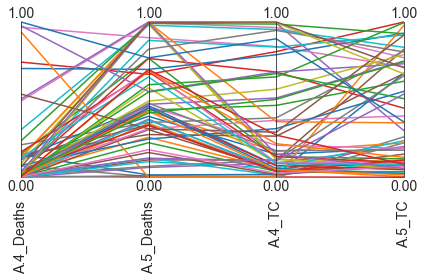

In [23]:
limits = parcoords.get_limits(worst_regret_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_45)
plt.savefig('./figures/minimax_norm_45_undominated.png')

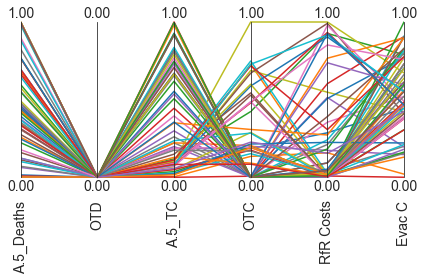

In [24]:
limits = parcoords.get_limits(worst_regret_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_others5)
plt.savefig('./figures/minimax_norm_others5_undominated.png')

In [25]:
worst_regret_norm_45_dominate = worst_regret_norm_45.drop(dominate(worst_regret_norm_45))
worst_regret_norm_others5_dominate = worst_regret_norm_others5.drop(dominate(worst_regret_norm_others5))

In [31]:
most_pref = most_pref.set_index('policy')

,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Costs
policy,,,,,,,,
Policy 0,8.453408e+06,0.0,9.545879e+07,0.0,1.343800e+09,0.000000,0.0,4.063320e+08
Policy 1,2.078505e+07,0.0,1.462890e+08,0.0,4.789000e+08,0.000000,0.0,2.127035e+08
Policy 10,1.692524e+07,0.0,7.770751e+07,0.0,0.000000e+00,141.914208,0.0,3.840111e+08
Policy 11,1.106877e+07,0.0,7.074086e+07,0.0,0.000000e+00,0.000000,0.0,2.484557e+08
Policy 12,7.332080e+06,0.0,1.341380e+08,0.0,2.015900e+09,0.000000,0.0,6.902568e+08
...,...,...,...,...,...,...,...,...
Policy 76,7.332080e+06,0.0,1.389496e+08,0.0,1.792200e+09,0.000000,0.0,2.762047e+08
Policy 78,1.258646e+07,0.0,1.303402e+08,0.0,2.365000e+08,0.000000,0.0,2.036767e+08
Policy 79,2.811056e+07,0.0,1.643440e+08,0.0,1.153000e+08,0.000000,0.0,4.911282e+08


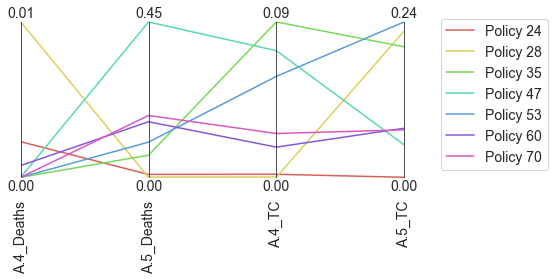

In [39]:
policies_minimax_45 = axes_paraplot(worst_regret_norm_45_dominate, most_pref, 'minimax_norm_45_dominated')

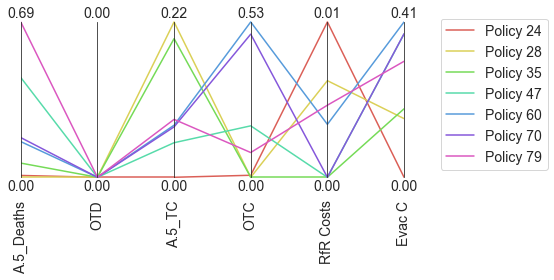

In [40]:
policies_minimax_others5 = axes_paraplot(worst_regret_norm_others5_dominate, most_pref, 'minimax_norm_others5_dominated')

In [41]:
policies_minimax_45

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 53',
       'Policy 60', 'Policy 70'], dtype=object)

In [46]:
policies_minimax_others5

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60',
       'Policy 70', 'Policy 79'], dtype=object)

In [73]:
policies_levers = experiments_load.groupby('policy').min()
policies_levers = policies_levers[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_levers.to_csv('./outcomes/all_policies.csv')

In [72]:
# check if policies with no dike increase in Deventer
no_dike5_increase = policies_levers[(policies_levers['A.5_DikeIncrease 0'] == 0) & (policies_levers['A.5_DikeIncrease 1'] == 0)
                                    & (policies_levers['A.5_DikeIncrease 2'] == 0)]
no_dike5_increase

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
policy,,,,,,,,,,,,,,,,,,,,,


In [298]:
policies_interesting = []
for i in range(len(policies)):
    for j in range(len(policy_names)):
        if policies[i].name == policy_names[j]:
            policies_interesting.append(policies[i])

In [305]:
policies_interesting

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 1, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 1, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 4, 'A.1_DikeIncrease 0': 1, 'A.1_DikeIncrease 1': 4, 'A.1_DikeIncrease 2': 6, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 3, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 2, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 4, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 5, 'A.5_DikeIncrease 1': 6, 'A.5_DikeIncrease 2': 2}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 1, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 1, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

In [291]:
policies_found

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


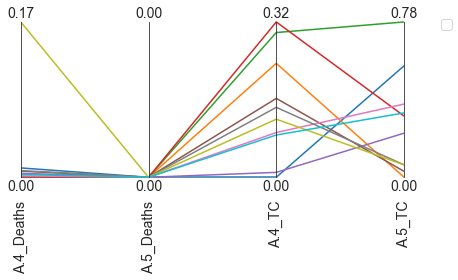

In [257]:
limits = parcoords.get_limits(policy_outcomes_regret_norm_4vs5)
axes = parcoords.ParallelAxes(limits)
axes.plot(policy_outcomes_regret_norm_4vs5)
axes.legend()

In [ ]:
dominaterestvs5 = dominate(policy_outcomes_regret_norm_restvs5)